In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import MultinomialNB



In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Load your data (already preprocessed)
df = pd.read_pickle("untracked_data/data_prepro_train_01.pkl")

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Baseline model: default CountVectorizer + default MultinomialNB(alpha=1.0)
baseline_model = make_pipeline(
    CountVectorizer(ngram_range = (1,1)),         # default: unigrams, no sparse-term removal
    MultinomialNB(alpha = 0, force_alpha=True)
)

# Evaluate
scores = cross_val_score(
    baseline_model,
    df['text'],
    df['label'],
    cv=kf,
    scoring='accuracy'
)

print(f"Baseline Naive Bayes accuracy (10-fold CV): {scores.mean():.4f}")


/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/benphelps/miniconda3/lib/python3.

Baseline Naive Bayes accuracy (10-fold CV): 0.5344


/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/benphelps/miniconda3/lib/python3.12/site-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Load data
df = pd.read_pickle("untracked_data/data_prepro_train_01.pkl")

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range = (1,2))), #(1,1) for unigrams, (1,2) for unigrams and bigrams
    # ('select', SelectPercentile(score_func=chi2)),
    ('nb', MultinomialNB(force_alpha=True))
])

param_grid = {
    # Rare-term removal as a fraction of documents
    'vectorizer__min_df': [1,2,3,5,10],   # 0.001 → 0.1
    # (Optional) also trim overly common terms
    # 'vectorizer__max_df': [0.8, 0.9, 1.0],

    # Percentile-based χ² feature selection (avoids k>n_features issues)
    # 'select__percentile': [10,20,30,50,70,90,100],

    # NB smoothing
    'nb__alpha': np.logspace(-3, 1, 8)
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(df['text'], df['label'])

print("Best params:", grid.best_params_)
print(f"Best mean CV accuracy: {grid.best_score_:.4f}")


Fitting 10 folds for each of 40 candidates, totalling 400 fits


ValueError: Invalid parameter 'alpha' for estimator Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('nb', MultinomialNB())]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

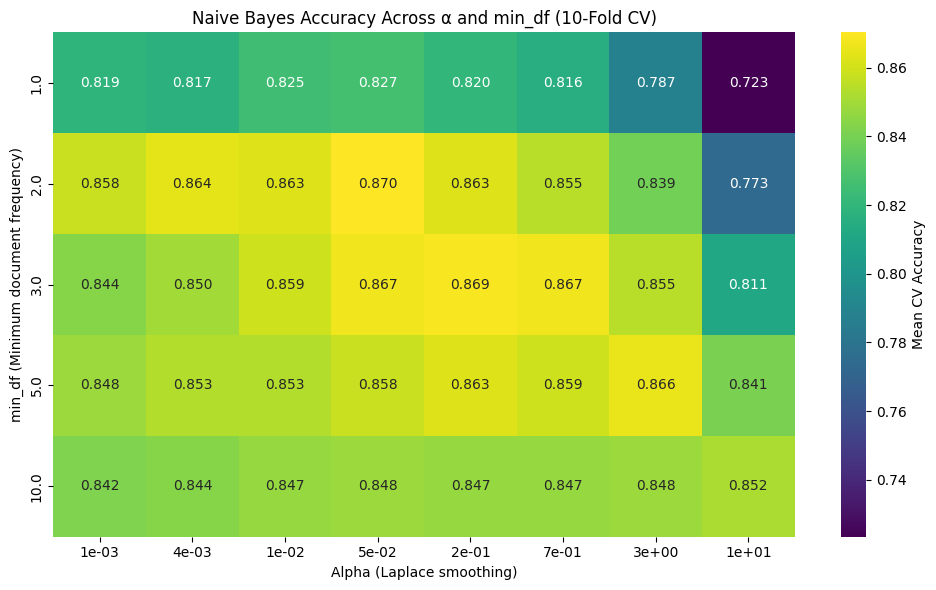

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract results
results = pd.DataFrame(grid.cv_results_)

# Keep only the parameters and mean test score
results = results[['param_vectorizer__min_df', 'param_nb__alpha', 'mean_test_score']]

# Convert parameter columns to numeric
results['param_vectorizer__min_df'] = results['param_vectorizer__min_df'].astype(float)
results['param_nb__alpha'] = results['param_nb__alpha'].astype(float)

# Pivot the results into a grid
pivot = results.pivot(
    index='param_vectorizer__min_df',
    columns='param_nb__alpha',
    values='mean_test_score'
)

# Sort for nice display
pivot = pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)

# Optional: format alpha labels in scientific notation for readability
# Format both axes in scientific notation
pivot.columns = [f"{a:.0e}" for a in pivot.columns]  # X-axis


# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Mean CV Accuracy'}
)

plt.title("Naive Bayes Accuracy Across α and min_df (10-Fold CV)")
plt.xlabel("Alpha (Laplace smoothing)")
plt.ylabel("min_df (Minimum document frequency)")
plt.tight_layout()
plt.show()

